Model params: 16.19 M
[ 0. 41. 42. 49.]
[ 0. 41. 42. 49.]
torch.Size([1, 128, 128])
[0. 1. 2. 9.]
(128, 128)


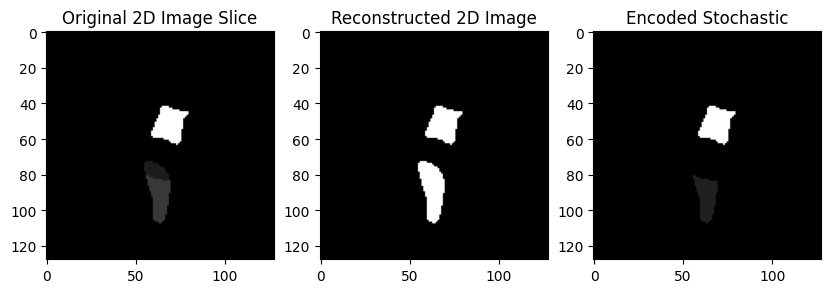

In [8]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torchvision import transforms
from BIDS import NII
from BIDS.core.np_utils import np_dice
import numpy as np
from BIDS.core.np_utils import np_map_labels, Label_Map

def map_labels_(seg_arr):
        seg_arr = np_map_labels(arr=seg_arr,label_map={49: 9})
        seg_arr = np_map_labels(arr=seg_arr,label_map={48: 8})
        seg_arr = np_map_labels(arr=seg_arr,label_map={47: 7})
        seg_arr = np_map_labels(arr=seg_arr,label_map={46: 6})
        seg_arr = np_map_labels(arr=seg_arr,label_map={45: 5})
        seg_arr = np_map_labels(arr=seg_arr,label_map={44: 4})
        seg_arr = np_map_labels(arr=seg_arr,label_map={43: 3})
        seg_arr = np_map_labels(arr=seg_arr,label_map={42: 2})
        seg_arr = np_map_labels(arr=seg_arr,label_map={41: 1})
        return seg_arr

nii = NII.load(
    "/media/DATA/martina_ma/datasets/verse011/verse011_008_subreg_cropped.nii.gz",
    True,
)
seg_arr = nii.get_seg_array()

# Load the checkpoint and move the model to the specified device
checkpoint_path = "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_108/checkpoints/epoch=47-step=144_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_105/checkpoints/epoch=69-step=210_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_63/checkpoints/epoch=79-step=240_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_60/checkpoints/epoch=71-step=216_latest.ckpt"#lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt"
device = "cuda:0"  # or "cpu" if you want to use CPU
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
model.ema_model.eval()
model.ema_model.to(device)

# Load the NIfTI image
overfit_sample_path = "/media/DATA/martina_ma/datasets/verse013/verse011_008_subreg_cropped.nii.gz"#verse013_021_subreg_cropped.nii.gz"#"/media/DATA/martina_ma/datasets/verse013_023_subreg_cropped.nii.gz"
img_nifti = seg_arr#nib.load(overfit_sample_path)
img_nifti = np_map_labels(arr=seg_arr,label_map={50: 49})

print(np.unique(img_slice))
# Extract a specific 2D slice from the 3D volume (e.g., the middle slice along the z-axis)
z_slice = img_nifti.shape[2] // 2  # Choose the middle slice or adjust as needed
img_slice = img_nifti[:, :,z_slice]#img_nifti.get_fdata()[:, :, z_slice]  # Extract the 2D slice
img_slice = map_labels_(img_slice)
img_slice = img_slice.astype(float)
print(np.unique(img_slice))
img_slice = map_labels_(img_slice)
#img_slice = img_slice/49
# Convert the 2D slice to a PyTorch tensor and preprocess it for the model (e.g., normalization), transforms.Normalize(mean, std)
transform = transforms.Compose([transforms.ToTensor()])
img_data = transform(img_slice).unsqueeze(0).to(device, dtype=torch.float32)
#print(img_data)
# Ensure that the input has a single channel (if the model expects 1 channel)
if img_data.shape[1] != 1:
    img_data = img_data.mean(1, keepdim=True)

# Encode the 2D image slice
cond = model.encode(img_data.to(device))

# Decode the encoded representation to obtain the reconstructed 2D image
T = 20  # Adjust T as needed
stoch = model.encode_stochastic(img_data.to(device), cond, T=250)
xT = model.render(stoch, cond, T=T) #pred = model.render(xT, cond, T=20)
reconstructed_img = xT#[0]#(xT[0] + 1) / 2  # De-normalize if needed
# Move the reconstructed_img to CPU
reconstructed_img = reconstructed_img.cpu()
print(reconstructed_img[0].shape)
print(np.unique(img_slice))
# Display the original and reconstructed 2D image slices
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img_slice, cmap="gray")
ax[0].set_title("Original 2D Image Slice")
ax[1].imshow(reconstructed_img[0].permute(1, 2, 0), cmap="gray") #.permute(1, 2, 0)
ax[1].set_title("Reconstructed 2D Image")
ax[2].imshow(stoch[0].permute(1, 2, 0).cpu(), cmap="gray")
ax[2].set_title("Encoded Stochastic")
print(img_slice.shape)
#ax[3].imshow(cond[0].permute(1, 2, 0).cpu(), cmap="gray")
#np_dice()
plt.show()


In [4]:
r = reconstructed_img[0][0].numpy().copy()
#r[r<=0.8] = 0
print(np_dice(img_slice, r, binary_compare= True))
print(np.unique(img_slice))
print(np.unique(reconstructed_img[0][0].numpy()))

0.07349050502675054
[ 0. 41. 42. 49.]
[-1.03900367e-02 -4.06098086e-03 -3.77950654e-03 -3.71381827e-03
 -3.57925519e-03 -3.37810628e-03 -3.02936882e-03 -2.58015329e-03
 -2.30966136e-03 -2.27634562e-03 -2.26939819e-03 -2.20130221e-03
 -2.18684506e-03 -2.17132550e-03 -2.04500882e-03 -1.95418997e-03
 -1.93560799e-03 -1.91415753e-03 -1.87891012e-03 -1.85244519e-03
 -1.83006434e-03 -1.81076233e-03 -1.77284854e-03 -1.70169421e-03
 -1.66138669e-03 -1.65276823e-03 -1.62841764e-03 -1.52099645e-03
 -1.50102517e-03 -1.49909861e-03 -1.48314971e-03 -1.47882453e-03
 -1.47589389e-03 -1.42567314e-03 -1.40757929e-03 -1.39401539e-03
 -1.35980535e-03 -1.35491719e-03 -1.35029317e-03 -1.33669015e-03
 -1.28153036e-03 -1.27100979e-03 -1.24206999e-03 -1.22926501e-03
 -1.18572754e-03 -1.14374317e-03 -1.12790929e-03 -1.12332043e-03
 -1.08360767e-03 -1.06934470e-03 -1.03906402e-03 -9.96668590e-04
 -9.90287634e-04 -9.48032131e-04 -9.34210373e-04 -9.05018242e-04
 -8.58029700e-04 -8.41095054e-04 -8.40047025e-04 -8.

[[ 9.7138323e-03  3.2023195e-02  2.5478905e-02 ...  2.7285542e-02
   3.3293359e-02  3.9880730e-02]
 [-8.8444464e-03 -9.3581708e-04 -1.0632949e-03 ...  1.6723085e-03
  -2.2392260e-04  1.5973389e-02]
 [ 2.8241924e-03  4.4431873e-03  4.8482516e-03 ...  1.0599796e-02
   3.4246775e-03  2.2142209e-02]
 ...
 [ 9.2146263e-05  1.1151505e-03  1.3472330e-03 ...  6.4185103e-03
   3.4140949e-03  2.2136483e-02]
 [ 9.5998934e-03  3.9938777e-03  4.3294299e-03 ...  6.8743867e-03
   3.9976151e-03  1.8700227e-02]
 [ 5.5930880e-03  3.9706412e-03  4.0490781e-03 ...  9.0445932e-03
   5.7395436e-03  3.8843253e-03]]
0.8295418
0.8294229
0.8298783
0.8295549
0.8282882
0.82855517
0.82918227
0.82940257
0.8287503
0.82814133
0.82803476
0.8286182
0.8291456
0.8279234
0.8278575
0.8280117
0.8289639
0.82882786
0.82807964
0.82824135
0.82837147
0.82987946
1.0
[ 0 42 43 50]
[ 0 41 42 43 44 49 50]


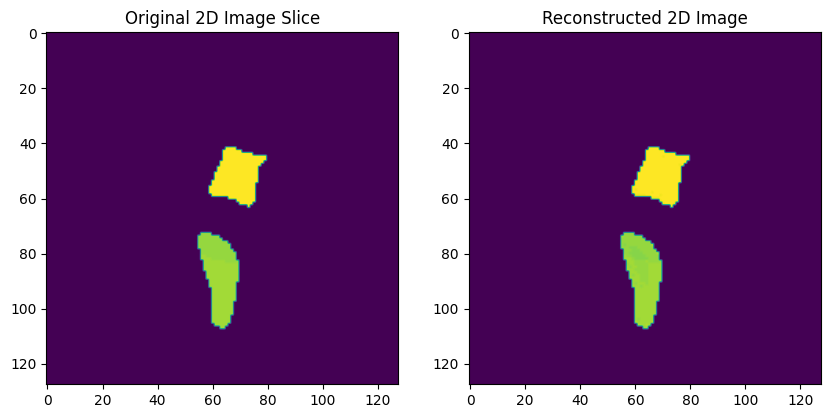

In [19]:
def map_labels(value):
    #[0.   0.82,41 0.84,42 0.86,43 0.88,44 0.9,45  0.92,46 0.94,47 0.96,48 0.98,49 1.,50  ]
    # todo auf 49 umskalieren
    if value <= 0.2:
        return 0
    if 0.8 <= value < 0.83:
        return 41
    if 0.83 <= value < 0.85:
        return 42
    if 0.85 <= value < 0.87:
        return 43
    if 0.87 <= value < 0.89:
        return 44
    if 0.89 <= value < 0.91:
        return 45
    if 0.91 <= value < 0.93:
        return 46
    if 0.93 <= value < 0.95:
        return 47
    if 0.95 <= value < 0.97:
        return 48
    if 0.97 <= value < 0.99:
        return 49
    if 0.99 <= value <= 1.5:
        return 50
    return value

r = reconstructed_img[0][0].numpy().copy()
print(r)
for i in r.flatten():
    if 0.8 <= i < 0.83:
        print(i) # wieso wird hier label 41 so viel predicted obwohl es gar nicht auftaucht im orig img?
r = np.vectorize(lambda x: map_labels(x))(r)

img_slice = np.vectorize(lambda x: map_labels(x))(img_slice)

print(np_dice(img_slice, r, binary_compare= True))
print(np.unique(img_slice))
print(np.unique(r))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_slice)
ax[0].set_title("Original 2D Image Slice")
ax[1].imshow(r) #.permute(1, 2, 0)
ax[1].set_title("Reconstructed 2D Image")


plt.show()
#[0.03684453 0.03727458 0.03753474 ... 0.98750603 0.98803204 0.9885488 ]


In [1]:
from dataloader import dataset_factory
from utils import arguments
import matplotlib.pyplot as plt
import numpy as np
import torch

opt = arguments.DAE_Option()
ds = dataset_factory.get_dataset(opt, super_res=False)
#batch = data[0e]

/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/media/DATA/martina_ma/datasets/test_csv.csv


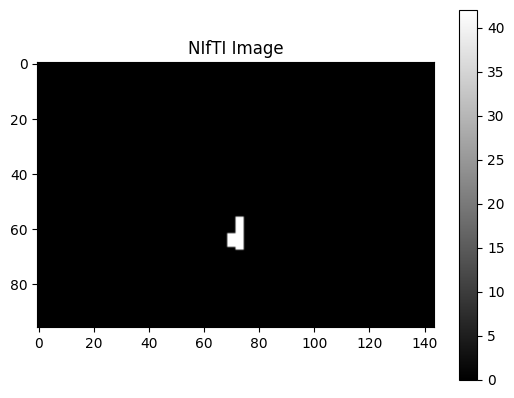

In [11]:
import matplotlib.pyplot as plt
import nibabel as nib
from BIDS.core.np_utils import np_dice
# Load the NIfTI image
overfit_sample_path = "/media/DATA/martina_ma/cutout/verse016/verse016_012_subreg_cropped.nii.gz"#"/media/DATA/martina_ma/datasets/verse011/verse011_008_subreg_cropped.nii.gz"#verse013_024_subreg_cropped.nii.gz"
img_nifti = nib.load(overfit_sample_path)

# Extract the image data as a NumPy array
img_data = img_nifti.get_fdata()
img_slice = img_data[100, :, :]
# Display the image using matplotlib
plt.imshow(img_slice, cmap="gray")  # Adjust the slice (60) as needed
plt.title("NIfTI Image")
plt.colorbar()
plt.show()


In [7]:
from coutouts import find_cutout, make_cutout
from BIDS import NII
from BIDS.core.np_utils import np_calc_crop_around_centerpoint, np_bbox_nd
from scipy import ndimage
import os

max_x = 0
max_y = 0
max_z = 0
max_cutout_size = (144, 96, 144)
subject = "verse406"
subreg_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-subreg_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse261_seg-subreg_msk.nii.gz",
    True,
)
vert_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-vert_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse261_seg-vert_msk.nii.gz",
    True,
)

vert_nii.rescale_()
vert_nii.reorient_()
subreg_nii.rescale_()
subreg_nii.reorient_()


labels = vert_nii.unique()
for label in labels:
    vert_label_nii = vert_nii.extract_label(label)
    vert_arr = vert_label_nii.get_seg_array()
    subreg_arr = subreg_nii.get_seg_array()#vert_arr_l1 = vert_L1.get_seg_array()
    subreg_arr_L1 = subreg_arr.copy()
    subreg_arr_L1[vert_arr == 0] = 0
    center_subreg = ndimage.center_of_mass(subreg_arr_L1)
    cropped_arr_subreg, cutout_coord_slices, padding = np_calc_crop_around_centerpoint(center_subreg, subreg_arr_L1, max_cutout_size)
#    nii_subreg_s = subreg_nii.set_array(cropped_arr_subreg)
    nii_subreg_s = subreg_nii.copy()
    nii_subreg_s.set_array_(cropped_arr_subreg)
    nii_subreg_s = nii_subreg_s.pad_to(max_cutout_size)
    nii_subreg_s.rescale_()
    nii_subreg_s.reorient_()
    #vert_label_nii.save("{}_{:03d}_vert_cropped.nii.gz".format(subject, label))
    folder = "/media/DATA/martina_ma/cutout/{}/".format(subject)
    if not os.path.exists(folder):
            os.makedirs(folder)
    nii_subreg_s.save("/media/DATA/martina_ma/cutout/{}/{}_{:03d}_subreg_cropped.nii.gz".format(subject,subject, label))


[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_007_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_008_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_009_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_010_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_011_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_012_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_013_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_014_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_015_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_016_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_017_subreg_cropped.nii.

In [6]:
from coutouts import find_cutout, make_cutout
from BIDS import NII
from BIDS.core.np_utils import np_calc_crop_around_centerpoint, np_bbox_nd
from scipy import ndimage
import os

subreg_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-subreg_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse626/sub-verse626_dir-iso_seg-subreg_msk.nii.gz",
    True,
)
vert_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-vert_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse626/sub-verse626_dir-iso_seg-vert_msk.nii.gz",
    True,
)

vert_nii.reorient_()
subreg_nii.reorient_()
vert_nii.rescale_()
subreg_nii.rescale_()


labels = vert_nii.unique()
for label in labels:
    cut_size = find_cutout(vert_nii, label, None)
    

(61, 28, 71) 7
(65, 34, 76) 8
(67, 36, 69) 9
(70, 34, 66) 10
(73, 32, 65) 11
(70, 38, 66) 12
(70, 51, 63) 13
(70, 54, 63) 14
(70, 53, 60) 15
(68, 52, 60) 16
(72, 48, 57) 17
(74, 46, 45) 18
(6, 12, 12) 19
(77, 51, 68) 20
(84, 57, 69) 21
(83, 57, 79) 22
(84, 49, 85) 23
(82, 45, 89) 24
(65, 62, 122) 25


In [9]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import nibabel as nib
first = ds[0]
print(type(first))
print(first)
print(ds)
batch = ds[0]['img'][None]
print(type(batch))
print(batch)

# def show(*img):
#     img = [i if len(i.shape) == 3 else i.squeeze(0) for i in img]
#     img = [(i.detach().cpu() if isinstance(i, torch.Tensor) else torch.from_numpy(i)) for i in img]
#     np_img = torch.cat(img, dim=-1).numpy()
#     plt.figure(figsize=(20, 6))
#     plt.imshow(np.transpose(np_img, (1, 2, 0)), interpolation="nearest", cmap="gray")

#show(*ds.get_img(9, 1).values())
""
#lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt
checkpoint_path = "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt"#"/media/data/robert/code/DiffAE/lightning_logs/DAE_NAKO_256/version_1/checkpoints/last.ckpt"
device: str | None = "cuda:0"
print("checkpoint_path", checkpoint_path)
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
model.ema_model.eval()
model.ema_model.to(device)

    #### Load overfit sample ####
overfit_sample_path = "/media/DATA/martina_ma/datasets/verse013_023_subreg_cropped.nii.gz"
img_nifti = nib.load(overfit_sample_path)

import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())
print("decode")
pred = model.render(xT, cond, T=20)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

NameError: name 'ds' is not defined

In [11]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
c = "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_19/checkpoints/last.ckpt"
print(Path(c).exists())
model: DAE_LitModel = DAE_LitModel.load_from_checkpoint(c)
#"lightning_logs/SuperDAE_DAE_NAKO_256/version_1/checkpoints/last.ckpt")
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_37/checkpoints/last.ckpt
#/media/DATA/martina_ma/dae
#lightning_logs/DAE_NAKO_256/version_36
#lightning_logs/DAE_NAKO_256/version_36/checkpoints/last.ckpt

True
Model params: 16.19 M


In [14]:
device = torch.device("cuda:0")
#data = ds.get_img(8, 0)
# img_lr: torch.Tensor = data["img_lr"]
# img_lr.unsqueeze_(0)
# img_lr = img_lr.to(device)
# img_hr = data["img"]
# img_hr.unsqueeze_(0)

img_lr = batch[0]#.permute([1, 2, 0])
img_lr.unsqueeze_(0)
img_lr = img_lr.to(device)
cond = model.encode(img_lr)

xT = model.encode_stochastic(img_lr, cond, T=250)
pred = model.render(xT, cond, T=20)
pred2 = model.render(torch.randn_like(img_lr), cond, T=20)
pred3 = model.render(xT * 0.2, cond, T=20)


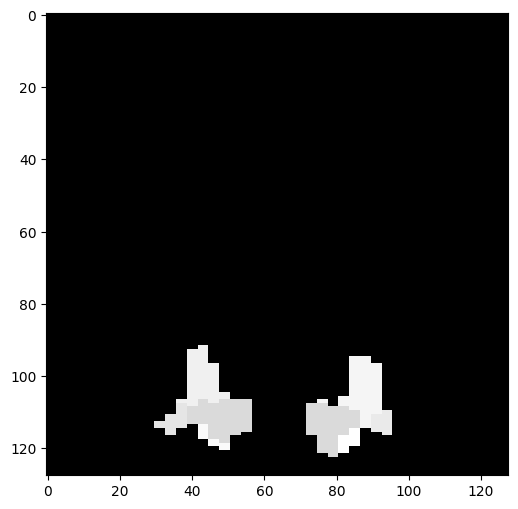

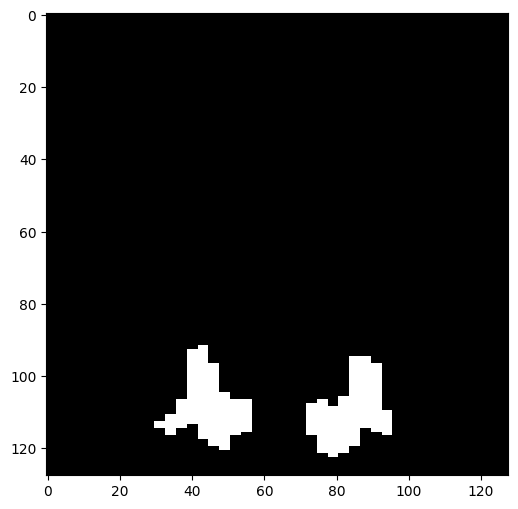

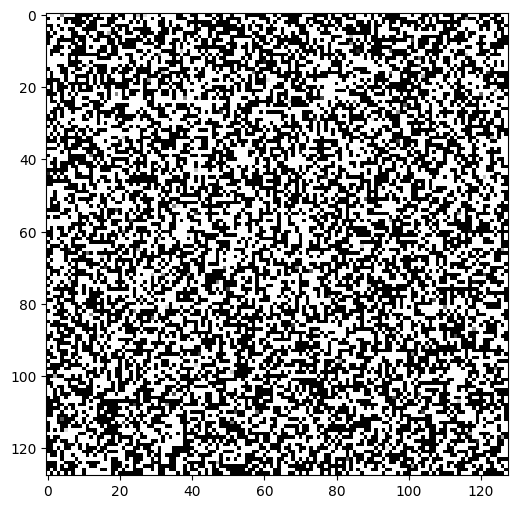

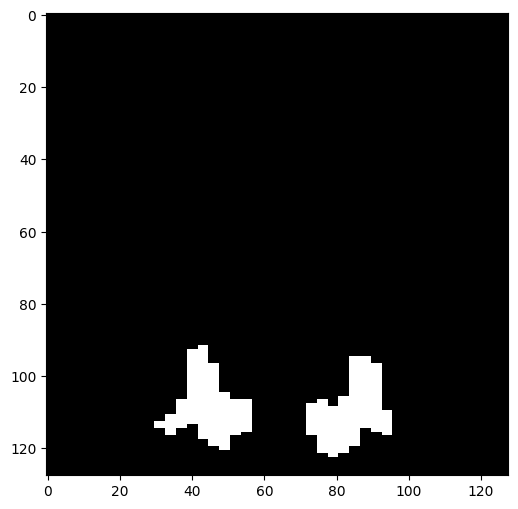

In [18]:
show(img_lr)
show(pred)
show(pred2)
show(pred3)

In [19]:
print(xT.min(), xT.max())
n = torch.randn_like(img_lr)
print(n.min(), n.max())

tensor(-0.0050, device='cuda:0') tensor(9399.8770, device='cuda:0')
tensor(-3.9598, device='cuda:0') tensor(3.8167, device='cuda:0')


In [20]:
from BIDS import NII
nifti = "/media/DATA/martina_ma/datasets/verse013_023_subreg_cropped.nii.gz" #"/media/data/robert/datasets/dataset-neuroboly/rawdata/sub-m034619/ses-20140114/anat/sub-m034619_ses-20140114_acq-ax_chunk-2_T2w.nii.gz"
nii = NII.load(nifti,
    False,
)
nii.reorient_().rescale_((0.8571, 0.8571, 0.8571))

# show(arr)

ModuleNotFoundError: No module named 'BIDS.core'

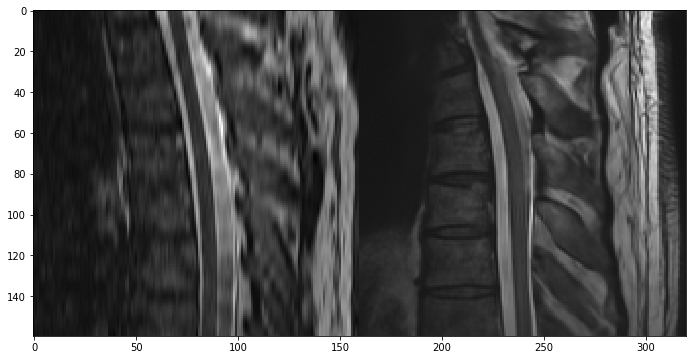

In [141]:
arr_new = nii.get_array()[:, :, nii.shape[-1] // 2]
from dataloader.datasets.dataset_superres import get_pads, target_pad

arr, _ = target_pad(arr_new, [160, 160])
a = 50
arr = arr[a : 160 + a, :160]


img_lr = torch.from_numpy(arr.T).unsqueeze_(0).unsqueeze_(0).to(device, torch.float32)
img_lr /= img_lr.max()
img_lr = img_lr * 2 - 1
cond = model.encode(img_lr)
pred2 = model.render(torch.randn_like(img_lr), cond, T=20)
show(img_lr.cpu().numpy(), pred2.cpu().numpy())

In [112]:
print(nii.shape)
print(nii.orientation)

(275, 188, 275)
('P', 'I', 'R')


In [163]:
a = 90

show(img_lr[..., :160, a : 160 + a])

ValueError: axes don't match array

<Figure size 1440x432 with 0 Axes>